<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_NormAndLightingBatchTransformsCPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
# colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#colab
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
# colab
!pip install fastai2 --upgrade > /dev/null
!pip freeze | grep fastai2

fastai2==0.0.18


In [ ]:
#colab
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null
!pip freeze | grep fastai_xla_extensions

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-ha5vbe09


In [ ]:
#colab
!pip install git+https://github.com/butchland/my_timesaver_utils > /dev/null
!pip freeze | grep my_timesaver_utils

  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-e43uj05b


### Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai_xla_extensions.core import *

In [ ]:
from fastai2.vision.all import *

In [ ]:
from my_timesaver_utils.profiling import *

### Setup data

In [ ]:
path = untar_data(URLs.PETS)/'images'

### Loop through batch and walk through batch transforms

In [ ]:
# from IPython.core.debugger import set_trace

In [ ]:
# TRACE = True

In [ ]:
orig_randtransform_call = RandTransform.__call__
def __call__(self, b, split_idx=None, **kwargs):
    is_lighting_tfm = isinstance(self, LightingTfm) 
    if is_lighting_tfm:
#         print(f'applying AffineCoordTfm call {self}')
#         if TRACE: set_trace()
        start_record('lighting_tfm_call')
    results = orig_randtransform_call(self, b, split_idx, **kwargs)
    if is_lighting_tfm:
        end_record('lighting_tfm_call')
    return results

In [ ]:
setattr(RandTransform,'__call__', __call__)

In [ ]:
# orig_normalize_encodes = Normalize.encodes

# def encodes(self, x:TensorImage):
#     start_record('normalize_encodes')
#     results = orig_normalize_encodes(self,x)
#     end_record('normalize_encodes')
#     return results

In [ ]:
# setattr(Normalize,'encodes', encodes)

In [ ]:
# def mycompose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
#     "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
#     if reverse: tfms = reversed(tfms)
#     for f in tfms:
#         if not is_enc: f = f.decode
#         if isinstance(f,AffineCoordTfm): 
#             print(f'applying {type(f)} {f} to {type(x)}')
#             if TRACE:
#                 set_trace()
#         x = f(x, **kwargs)
#     return x


In [ ]:
# @patch_to(Pipeline)
# def __call__(self, o): return mycompose_tfms(o, tfms=self.fs, split_idx=self.split_idx)

In [ ]:
# TRACE = False

In [ ]:
batch_tfms = [*aug_transforms(max_zoom=1.0, max_warp=0., max_rotate=0., max_lighting=0.2,do_flip=False)]
batch_tfms

[LightingTfm: (TensorImage,object) -> encodes ]

In [ ]:
batch_tfms[0].fs

(#2) [<fastai2.vision.augment._BrightnessLogit object at 0x7f42731cd748>,<fastai2.vision.augment._ContrastLogit object at 0x7f42731cd7b8>]

In [ ]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
   
)

In [ ]:
print_prof_data()

In [ ]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_36.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_36.jpg
    applying partial gives
      saint_bernard
    applying Categorize gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(30))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=500x333, TensorCategory(30))
    applying Res

In [ ]:
print_prof_data()

Function lighting_tfm_call called 2 times.
Execution time max: 0.072, average: 0.037


### Setup DataLoaders

In [ ]:
bs=256

In [ ]:
dls = datablock.dataloaders(path,bs=bs)

In [ ]:
dls.device

device(type='cpu')

In [ ]:
dls.train

In [ ]:
train_dl = dls.train

In [ ]:
train_dl.device

device(type='cpu')

In [ ]:
# def fetch_one_batch():
#     if TRACE: set_trace()
#     dl_iter = train_dl.__iter__()
#     b = dl_iter.__next__()

In [ ]:
# TRACE = False

In [ ]:
clear_prof_data();print_prof_data()

In [ ]:
# fetch_one_batch()

In [ ]:
# print_prof_data()

In [ ]:
clear_prof_data(); print_prof_data()

In [ ]:
def fetch_all_batches():
    for b in train_dl:
        pass

In [ ]:
fetch_all_batches()

In [ ]:
print_prof_data()

Function lighting_tfm_call called 23 times.
Execution time max: 1.313, average: 0.676


In [ ]:
times = get_prof_data('lighting_tfm_call')

In [ ]:
# times2 = get_prof_data('normalize_encodes')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
times

[1.312922716140747,
 0.7254865169525146,
 0.5502560138702393,
 0.6936094760894775,
 0.5870380401611328,
 0.5664598941802979,
 0.8293423652648926,
 0.7417974472045898,
 0.6956570148468018,
 0.597170352935791,
 0.7398011684417725,
 0.606464147567749,
 0.7865958213806152,
 0.6803274154663086,
 0.6039526462554932,
 0.719200611114502,
 0.6418707370758057,
 0.6978912353515625,
 0.6025621891021729,
 0.6672351360321045,
 0.5570170879364014,
 0.6070263385772705,
 0.3453962802886963]

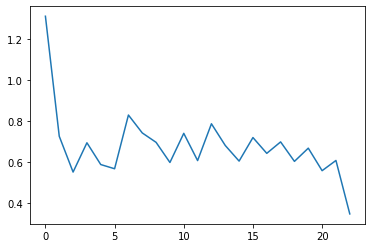

In [ ]:
plt.plot(times);

In [ ]:
# times2

In [ ]:
# plt.plot(times2);